In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load dataset

In [12]:
probabilistic_data = pd.read_csv("../data/gtzan/features/features_pruned.csv")

## Models
### Features and labels

In [13]:
x,y=probabilistic_data.loc[:,(probabilistic_data.columns!="label")],probabilistic_data["label"].values
x.head()

,spectral_contrast5,spectral_contrast4,spectral_contrast7,spectral_rolloff_mean,spectral_flatness_mean,spectral_centroid_mean,spectral_contrast3,mfcc1,rms_mean,rms_std,...,spectral_slope_mean,mfcc15,mfcc5,mfcc3,auto_corr_coeff_std,mfcc51,mfcc10,mfcc52,mfcc23,spectral_entropy
0,-0.510941,-0.447034,-0.971347,2.517435,2.174226,2.686513,-0.839848,1.300945,1.253661,0.631785,...,0.598906,1.103352,1.015553,0.996309,-0.499317,0.576670,-0.686375,0.542929,1.148055,1.575717
1,-1.254876,-1.121964,1.405315,0.387051,-0.074434,0.714162,-1.056324,1.162001,0.200989,-1.214462,...,-2.363023,-1.248536,-1.744524,-1.604644,-1.650243,0.064579,2.135377,-1.476451,-0.325966,1.742281
2,-0.407521,-0.757447,1.250187,0.250346,-0.237756,0.212807,-0.689792,0.985124,0.428234,-0.226710,...,-1.493490,-0.795014,-1.343227,-1.068187,-0.733646,1.542514,1.380669,0.979876,-0.519989,1.180192
3,-0.189241,-0.263669,1.137944,-0.000802,-0.549718,-0.096023,-0.304409,0.380975,-0.105747,-0.673396,...,-0.023527,-1.533392,-0.720989,-0.518036,-0.878726,0.515221,1.044117,-1.082304,1.448863,0.894281
4,-0.362506,-0.272579,-0.734906,-0.940289,-0.506559,-0.808737,-0.838219,0.510223,0.223786,-0.911741,...,-0.981726,-0.745817,-0.678625,-1.669618,-1.358617,-1.025244,-1.228204,-0.622991,-1.797249,0.137623


### Model fitting & Evaluation  

#### Model evaluation
- Accuracy which is defined by $$\frac{T_p+T_N}{T_p+T_N+F_p+F_N}$$
indicates percentage of observations that were correctly classified 
- Precision which is defined by $$\frac{T_p}{T_p+F_p}$$
is the ratio of correctly predicted positive observations to the total predicted positive observations. 
- Recall (Sensitivity) which is given by $$\frac{T_p}{T_p+F_N}$$  is the ratio of correctly predicted positive observations to the all observations in actual class 

- Confusion matrices a tabular method for visualising between the predicted
class and the true class

In [18]:
def numeric_metrics(model):
    scores = cross_validate(model, x, y, scoring=["accuracy","precision_macro","recall_macro"],cv=10)
    accuracy_mean,accuracy_std=(scores["test_accuracy"].mean()*100,100*scores["test_accuracy"].std())
    recall_mean,recall_std=(scores["test_recall_macro"].mean()*100,100*scores["test_recall_macro"].std())
    precision_mean,precision_std=(scores["test_precision_macro"].mean()*100,100*scores["test_precision_macro"].std())
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_mean,accuracy_std))
    print("Recall: %0.2f (+/- %0.2f)" % (recall_mean,recall_std))
    print("Precision: %0.2f (+/- %0.2f)" % (precision_mean,precision_std))
    print("Fitting time :",scores["fit_time"].mean())
    
def visual_metrics(model,name):
    sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    y_predict=cross_val_predict(model,x,y,cv=10)
    multiclass_confusion_matrix=confusion_matrix(y,y_predict)
    plt.figure(figsize=(10,10))
    plt.rc('xtick',labelsize=17)
    plt.rc('ytick',labelsize=17)
    ax= plt.subplot()
    sns.heatmap(multiclass_confusion_matrix, annot=True, ax = ax,fmt='g',
                annot_kws={"size": 20})
    ax.set_xlabel('Classified',size=18)
    ax.set_ylabel('True',size=18) 
    ax.xaxis.set_ticklabels([("G"+str(i)).translate(sub) for i in range(1,11)]) 
    ax.yaxis.set_ticklabels([("G"+str(i)).translate(sub) for i in range(1,11)])
    plt.savefig(name+".png",cmap="gray")
    plt.show()

#### Support Vector Machine
A support vector machine with a radial kernel function, in which the tolerance is $10^{-3}$ and the regularization strength $C=\frac{1}{6}$ and a one versus rest decision function.

Accuracy: 80.80 (+/- 3.94)
Recall: 80.80 (+/- 3.94)
Precision: 81.92 (+/- 4.12)
Fitting time : 0.30748376846313474


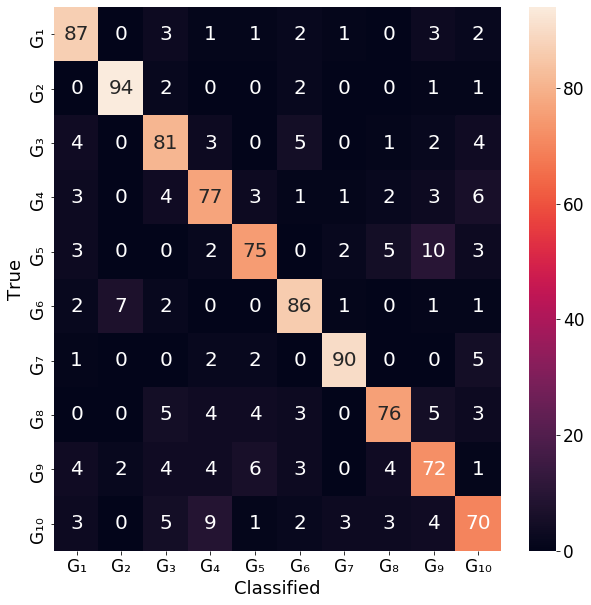

In [19]:
svm=load('../models/svm.joblib')
numeric_metrics(svm)
visual_metrics(svm,"svm")

#### Multilayer perceptron (Neural network)
Multilayer perceptron in which the activation function for all neurons is the relu function. The network architecture is such that we have 2 hidden layers which the first consist of 52 neurons which is approximatley half the number of input neurons and the second consist of 10 neurons which is the number of classes. The newtwork learning rate is fixed at $0.02$ and uses the adam optimizer.

Accuracy: 77.30 (+/- 4.69)
Recall: 77.30 (+/- 4.69)
Precision: 78.15 (+/- 4.77)
Fitting time : 0.2341552734375


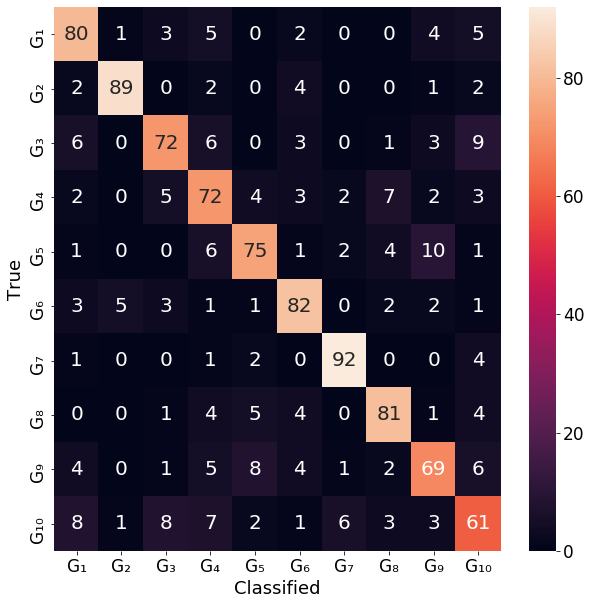

In [20]:
mlp=load('../models/mlp.joblib')
numeric_metrics(mlp)
visual_metrics(mlp,"mlp")

#### Logistic regression
Logistic regression which uses the one vs rest strategy for multiclass classification. The optimizer is newton-cg with default tolerance of $10^{-4}$ and regularization strength of $0.91$, number of iterations is $500$.

Accuracy: 75.80 (+/- 4.14)
Recall: 75.80 (+/- 4.14)
Precision: 76.48 (+/- 4.58)
Fitting time : 0.22434713840484619


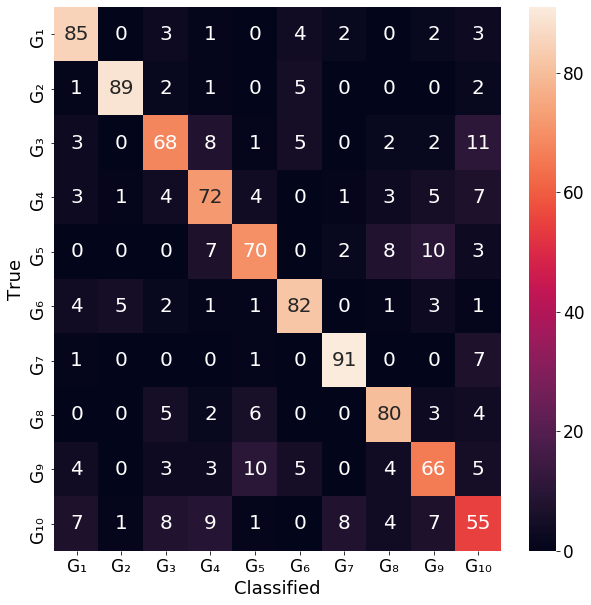

In [9]:
lgr=load('../models/lgr.joblib')
numeric_metrics(lgr)
visual_metrics(lgr,"lgr")

#### Random Forest
Random forest in which we us the entropy function to measure the quality of a split. The maximum depth is $100$.

Accuracy: 72.40 (+/- 3.90)
Recall: 72.40 (+/- 3.90)
Precision: 73.40 (+/- 4.64)
Fitting time : 0.4621959924697876


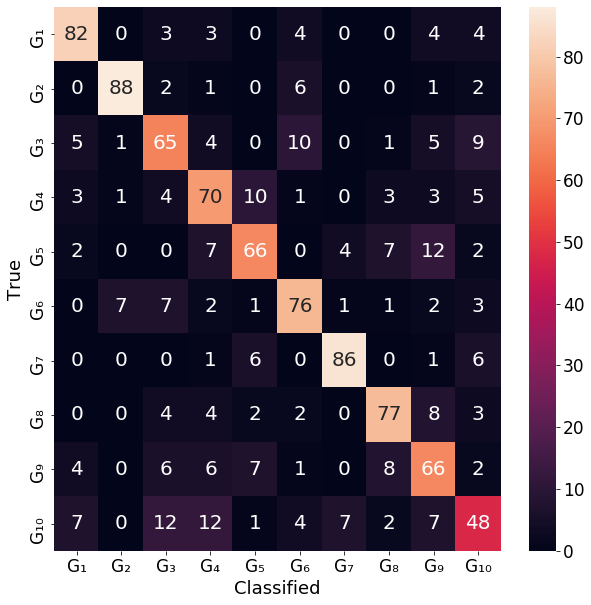

In [12]:
rf=load('../models/rf.joblib')
numeric_metrics(rf)
visual_metrics(rf,"rf")

#### $k$ Nearest Neighbours
$7$ nearest neighbours classifier, the distance metric is the manhattan  distance and distance weighting is used.

Accuracy: 69.70 (+/- 4.17)
Recall: 69.70 (+/- 4.17)
Precision: 72.49 (+/- 3.99)
Fitting time : 0.0018738031387329102


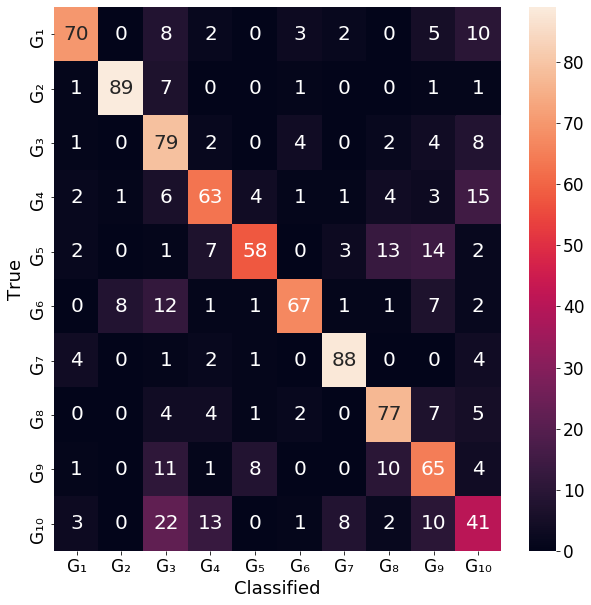

In [14]:
knn=load("../models/knn.joblib")
numeric_metrics(knn)
visual_metrics(knn,"knn")

#### Naive Bayes
Gaussian naive bayes with smoothing.

Accuracy: 54.50 (+/- 3.98)
Recall: 54.50 (+/- 3.98)
Precision: 55.55 (+/- 5.62)
Fitting time : 0.0039970636367797855


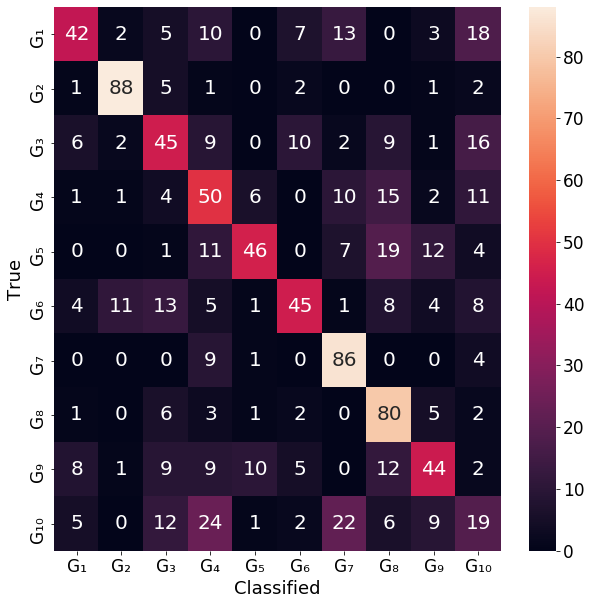

In [15]:
nb=load("../models/nb.joblib")
numeric_metrics(nb)
visual_metrics(nb,"nb")